<a href="https://colab.research.google.com/github/ben854719/Arctic-BlueSense-AI-Powered-Ocean-Monitoring/blob/main/ML_Defense_and_Environment_Arctic_Ocean.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from IPython import get_ipython
from IPython import display
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# 1. LOAD DATA
df = pd.DataFrame({
    "feature_num1": np.random.randn(500),
    "feature_num2": np.random.randn(500) * 10 + 5,
    "feature_cat": np.random.choice(["A", "B", "C"], size=500),
    "target": np.random.randn(500) * 2 + 1
})

X = df.drop("target", axis=1)
y = df["target"].values

# SCIKIT-LEARN PREPROCESSING PIPELINE
numeric_features = ["feature_num1", "feature_num2"]
categorical_features = ["feature_cat"]

preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), numeric_features),
        ("cat", OneHotEncoder(sparse_output=False), categorical_features)
    ]
)

# Fit the preprocessor.
preprocessor.fit(X)

# Transform data
X_processed = preprocessor.transform(X)


# TRAIN/TEST SPLIT.
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# PYTORCH DATASET WRAPPER.
class TabularDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32).view(-1, 1)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_ds = TabularDataset(X_train, y_train)
test_ds = TabularDataset(X_test, y_test)

train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

# PYTORCH MODEL.
class MLPRegressor(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        )

    def forward(self, x):
        return self.net(x)

model = MLPRegressor(input_dim=X_train.shape[1])

# 6. TRAINING SETUP.
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

# 7. TRAINING LOOP.
def train(model, loader):
    model.train()
    total_loss = 0
    for Xb, yb in loader:
        optimizer.zero_grad()
        preds = model(Xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(loader)

# 8. EVALUATION LOOP.

def evaluate(model, loader):
    model.eval()
    total_loss = 0
    with torch.no_grad():
        for Xb, yb in loader:
            preds = model(Xb)
            loss = criterion(preds, yb)
            total_loss += loss.item()
    return total_loss / len(loader)

# RUN TRAINING.
EPOCHS = 30
for epoch in range(EPOCHS):
    train_loss = train(model, train_loader)
    test_loss = evaluate(model, test_loader)
    print(f"Epoch {epoch+1}/{EPOCHS} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f}")

# INFERENCE EXAMPLE.
sample = X.iloc[[0]]
sample_processed = preprocessor.transform(sample)
sample_tensor = torch.tensor(sample_processed, dtype=torch.float32)

prediction = model(sample_tensor).item()
print("Prediction:", prediction)

Epoch 1/30 | Train Loss: 5.0522 | Test Loss: 3.8844
Epoch 2/30 | Train Loss: 4.6795 | Test Loss: 3.6006
Epoch 3/30 | Train Loss: 4.5201 | Test Loss: 3.5478
Epoch 4/30 | Train Loss: 4.4274 | Test Loss: 3.5713
Epoch 5/30 | Train Loss: 4.4796 | Test Loss: 3.6009
Epoch 6/30 | Train Loss: 4.4332 | Test Loss: 3.6086
Epoch 7/30 | Train Loss: 4.6234 | Test Loss: 3.6350
Epoch 8/30 | Train Loss: 4.3249 | Test Loss: 3.6315
Epoch 9/30 | Train Loss: 4.4004 | Test Loss: 3.6705
Epoch 10/30 | Train Loss: 4.2958 | Test Loss: 3.6964
Epoch 11/30 | Train Loss: 4.4177 | Test Loss: 3.7006
Epoch 12/30 | Train Loss: 4.2832 | Test Loss: 3.7377
Epoch 13/30 | Train Loss: 4.2946 | Test Loss: 3.7661
Epoch 14/30 | Train Loss: 4.3136 | Test Loss: 3.7704
Epoch 15/30 | Train Loss: 4.3312 | Test Loss: 3.8009
Epoch 16/30 | Train Loss: 4.2671 | Test Loss: 3.8146
Epoch 17/30 | Train Loss: 4.2025 | Test Loss: 3.8193
Epoch 18/30 | Train Loss: 4.2175 | Test Loss: 3.8406
Epoch 19/30 | Train Loss: 4.2156 | Test Loss: 3.8503
Ep

In [ ]:
# formula for torch save.
torch.save(model.state_dict(), 'model.pth')

In [ ]:
# Load the model.
input_dim_for_loading = X_train.shape[1]
model = MLPRegressor(input_dim=input_dim_for_loading)

# Load the state dictionary directly into the model
model.load_state_dict(torch.load('model.pth', weights_only=True))

# Set the model to evaluation mode.
model.eval()

# Convert X_test and y_test numpy arrays to PyTorch tensors for evaluation.
x_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

# Replace NaN Values in x_test_tensor and y_test_tensor with 0.
x_test_tensor[torch.isnan(x_test_tensor)] = 0
y_test_tensor[torch.isnan(y_test_tensor)] = 0

# Make predictions and calculate MSE.
with torch.no_grad():
    predictions = model(x_test_tensor)
    # Use the 'criterion' (nn.MSELoss()) defined in the training cell for consistency.
    MSE = criterion(predictions, y_test_tensor)
    display.display(MSE)

tensor(4.6581)

In [ ]:
X_sea_ice = sea_ice[['Year']]
y_sea_ice = sea_ice['SeaIce']

# 2. Perform train-test split
X_train_sea_ice, X_test_sea_ice, y_train_sea_ice, y_test_sea_ice = train_test_split(
    X_sea_ice, y_sea_ice, test_size=0.2, random_state=42
)

# 3. Initialize StandardScaler for 'Year' feature
scaler_X_sea_ice = StandardScaler()
X_train_scaled_sea_ice = scaler_X_sea_ice.fit_transform(X_train_sea_ice)
X_test_scaled_sea_ice = scaler_X_sea_ice.transform(X_test_sea_ice)

# 4. Initialize StandardScaler for 'SeaIce' target and name it scaler_y
scaler_y_sea_ice = StandardScaler()
y_train_scaled_sea_ice = scaler_y_sea_ice.fit_transform(y_train_sea_ice.values.reshape(-1, 1))
y_test_scaled_sea_ice = scaler_y_sea_ice.transform(y_test_sea_ice.values.reshape(-1, 1))

# 5. Create instances of TabularDataset
train_ds_sea_ice = TabularDataset(X_train_scaled_sea_ice, y_train_scaled_sea_ice.flatten())
test_ds_sea_ice = TabularDataset(X_test_scaled_sea_ice, y_test_scaled_sea_ice.flatten())

# 6. Create DataLoader instances
train_loader_sea_ice = DataLoader(train_ds_sea_ice, batch_size=32, shuffle=True)
test_loader_sea_ice = DataLoader(test_ds_sea_ice, batch_size=32)

# 7. Initialize a new MLPRegressor model (input_dim will be 1 for 'Year')
model_sea_ice = MLPRegressor(input_dim=X_train_scaled_sea_ice.shape[1])

# 8. Set up criterion and optimizer for the new model
criterion_sea_ice = nn.MSELoss()
optimizer_sea_ice = torch.optim.Adam(model_sea_ice.parameters(), lr=1e-3)

print("Data preparation, scaling, dataset/dataloader creation, and model initialization for sea ice prediction complete.")

Data preparation, scaling, dataset/dataloader creation, and model initialization for sea ice prediction complete.


In [ ]:
EPOCHS_SEA_ICE = 30
for epoch in range(EPOCHS_SEA_ICE):
    train_loss_sea_ice = train(model_sea_ice, train_loader_sea_ice)
    test_loss_sea_ice = evaluate(model_sea_ice, test_loader_sea_ice)
    print(f"Epoch {epoch+1}/{EPOCHS_SEA_ICE} | Train Loss: {train_loss_sea_ice:.4f} | Test Loss: {test_loss_sea_ice:.4f}")

print("Sea ice prediction model training complete.")

Epoch 1/30 | Train Loss: 1.1528 | Test Loss: 0.9513
Epoch 2/30 | Train Loss: 0.9783 | Test Loss: 0.9513
Epoch 3/30 | Train Loss: 1.0901 | Test Loss: 0.9513
Epoch 4/30 | Train Loss: 0.9702 | Test Loss: 0.9513
Epoch 5/30 | Train Loss: 0.8627 | Test Loss: 0.9513
Epoch 6/30 | Train Loss: 0.9324 | Test Loss: 0.9513
Epoch 7/30 | Train Loss: 1.1255 | Test Loss: 0.9513
Epoch 8/30 | Train Loss: 0.8540 | Test Loss: 0.9513
Epoch 9/30 | Train Loss: 0.9065 | Test Loss: 0.9513
Epoch 10/30 | Train Loss: 0.9387 | Test Loss: 0.9513
Epoch 11/30 | Train Loss: 0.8978 | Test Loss: 0.9513
Epoch 12/30 | Train Loss: 0.9801 | Test Loss: 0.9513
Epoch 13/30 | Train Loss: 1.1476 | Test Loss: 0.9513
Epoch 14/30 | Train Loss: 1.2626 | Test Loss: 0.9513
Epoch 15/30 | Train Loss: 1.1492 | Test Loss: 0.9513
Epoch 16/30 | Train Loss: 1.0376 | Test Loss: 0.9513
Epoch 17/30 | Train Loss: 1.0905 | Test Loss: 0.9513
Epoch 18/30 | Train Loss: 0.9481 | Test Loss: 0.9513
Epoch 19/30 | Train Loss: 0.9610 | Test Loss: 0.9513
Ep

In [ ]:
last_year = sea_ice['Year'].max()
future_years = np.arange(last_year + 1, 2101).reshape(-1, 1)
future_years_df = pd.DataFrame(future_years, columns=['Year'])
future_years_scaled = scaler_X_sea_ice.transform(future_years_df[['Year']])

print(f"Last year in dataset: {last_year}")
print(f"Shape of future_years_scaled: {future_years_scaled.shape}")
print("Future years data prepared and scaled.")

Last year in dataset: 2022
Shape of future_years_scaled: (78, 1)
Future years data prepared and scaled.


In [ ]:
future_years_tensor = torch.tensor(future_years_scaled, dtype=torch.float32)

# Set the model to evaluation mode
model_sea_ice.eval()

# Make predictions
with torch.no_grad():
    predictions_scaled = model_sea_ice(future_years_tensor)

# Convert predictions back to numpy array
predictions_scaled_np = predictions_scaled.numpy()

# Unscale the predictions
future_sea_ice_predictions = scaler_y_sea_ice.inverse_transform(predictions_scaled_np)

print("Future sea ice predictions generated and unscaled.")
print(f"First 5 predicted sea ice areas: {future_sea_ice_predictions[:5].flatten()}")
print(f"Shape of future_sea_ice_predictions: {future_sea_ice_predictions.shape}")

Future sea ice predictions generated and unscaled.
First 5 predicted sea ice areas: [1.3071337 1.3064442 1.30567   1.304896  1.3041219]
Shape of future_sea_ice_predictions: (78, 1)


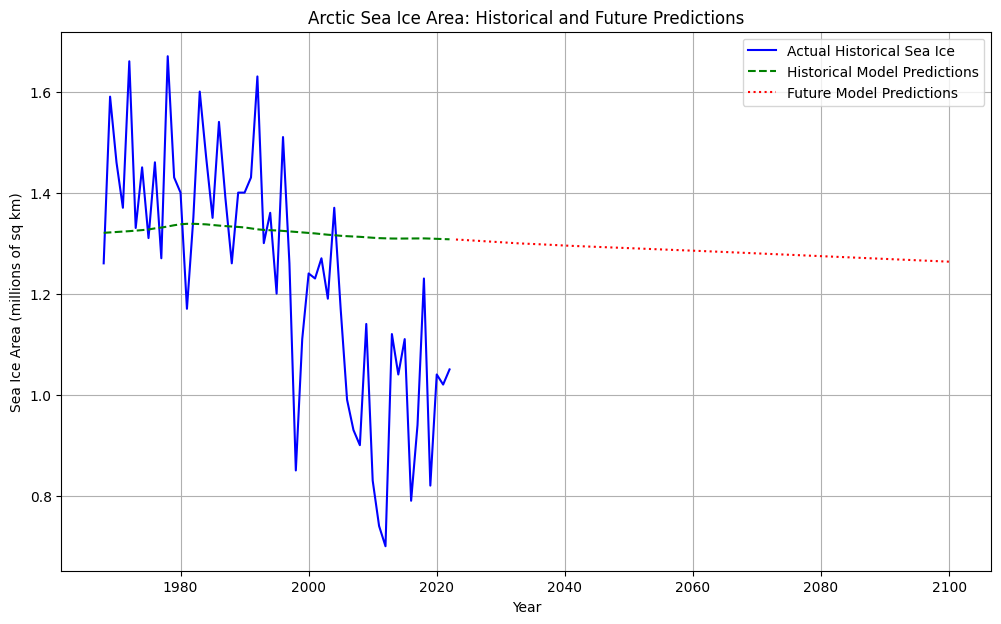

In [ ]:
X_sea_ice_tensor = torch.tensor(scaler_X_sea_ice.transform(X_sea_ice), dtype=torch.float32)

# Set the model to evaluation mode
model_sea_ice.eval()

# Make predictions on historical X_sea_ice
with torch.no_grad():
    historical_predictions_scaled = model_sea_ice(X_sea_ice_tensor)

# Unscale historical predictions
historical_predictions_unscaled = scaler_y_sea_ice.inverse_transform(historical_predictions_scaled.numpy())

# Create historical DataFrame
historical_df = pd.DataFrame({
    'Year': sea_ice['Year'],
    'Actual Sea Ice': sea_ice['SeaIce'],
    'Historical Predictions': historical_predictions_unscaled.flatten()
})

# Create future DataFrame (already have future_years and future_sea_ice_predictions)
future_df = pd.DataFrame({
    'Year': future_years.flatten(),
    'Future Predictions': future_sea_ice_predictions.flatten()
})

plt.figure(figsize=(12, 7))
sns.lineplot(x='Year', y='Actual Sea Ice', data=historical_df, label='Actual Historical Sea Ice', color='blue')
sns.lineplot(x='Year', y='Historical Predictions', data=historical_df, label='Historical Model Predictions', color='green', linestyle='--')
sns.lineplot(x='Year', y='Future Predictions', data=future_df, label='Future Model Predictions', color='red', linestyle=':')

plt.title('Arctic Sea Ice Area: Historical and Future Predictions')
plt.xlabel('Year')
plt.ylabel('Sea Ice Area (millions of sq km)')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
Description:

The graph shows a long term decline in the Arctic sea levels, and the model predicts continued losses as climate change accelerates. Strengthening defense and intelligence capabilities in the Canadian Arctic is increasingly important in response to foreign threats.
